# Welcome

Regression mixture. Linear model to keep it simple.

First analyze data with known classes then unknown. 

Physical model. here linear. Simultaneous clustering & parameter inference 

In [1]:
from typing import Optional
import pickle
import itertools

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as sns
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from pathlib import Path

import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import theano.tensor as tt
import arviz as az
import statsmodels.api as sm

from two_models import plot_parameters

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Set some variables

In [2]:
THIS_PATH = Path.cwd()
TMP_PATH = THIS_PATH.joinpath("tmp")
TMP_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH = THIS_PATH.joinpath("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
NORMAL_FONTSIZE = 20
RANDOM_SEED = 17
CMAP_NAME = "tab10"

## Make synthetic data

Define a function that generate the data for two components.

In [3]:
def model(x, b0, b1):
    # two-parameter model.
    return b1 * x + b0

def make_data():
    np.random.seed(123)
    b0 = 0
    sigma = 2
    b1 = [-5, 5]
    # size = 250
    size1 = 25
    size2 = 35
    size = size1 + size2

    print("Number of data points", size1 + size2)
    print(f"Weight cmp1: {size1 / size:.2f}" )
    print(f"Weight cmp2: {size2 / size:.2f}")

    # Predictor variable
    # X1_1 = np.random.randn(size)
    X1_1 = np.linspace(-2, 2, size1)

    # Simulate outcome variable--cluster 1
    Y1 = model(X1_1, b0, b1[0]) + np.random.normal(loc=0, scale=sigma, size=size1)

    # Predictor variable
    # X1_2 = np.random.randn(size)
    X1_2 = np.linspace(-3, 3, size2)
    # Simulate outcome variable --cluster 2
    Y2 = model(X1_2, b0, b1[1]) + np.random.normal(loc=0, scale=sigma, size=size2)

    return b0, b1, sigma, X1_1, X1_2, Y1, Y2


Create data for the two components and make a joint data set with anonymous classes. The weights are the fraction of the data points generates by the two components.

In [4]:
b0, b1, sigma, x1, x2, y1, y2 = make_data()

# joint data set with anonymous classes
x = np.append(x1, x2)
y = np.append(y1, y2)

Number of data points 60
Weight cmp1: 0.42
Weight cmp2: 0.58


For reference this is how the data looks like. 

In [5]:
def sign(x):
    if x > 0: 
        return "+"
    else:
        return "-"

def plot_true_model(xs, ys, b0, b1, sigma):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    x_model = np.linspace(-3, 3)
    ax.set_title("Data and true models")

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for x, y in zip(xs, ys):
        color = next(colors)
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color=color,
        )

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for icmp, b1_ in enumerate(b1):
        color = next(colors)
        y_model = b0 + b1_ * x_model
        ax.plot(
            x_model,
            y_model,
            linestyle="-",
            color=color,
            label=f"Cmp {icmp}: {b0} {sign(b1_)} {np.abs(b1_)}x + N(0,{sigma})",
        )
    ax.legend(fontsize=20, title="Y = b0 + b1*x + N(0, s)")
    return fig


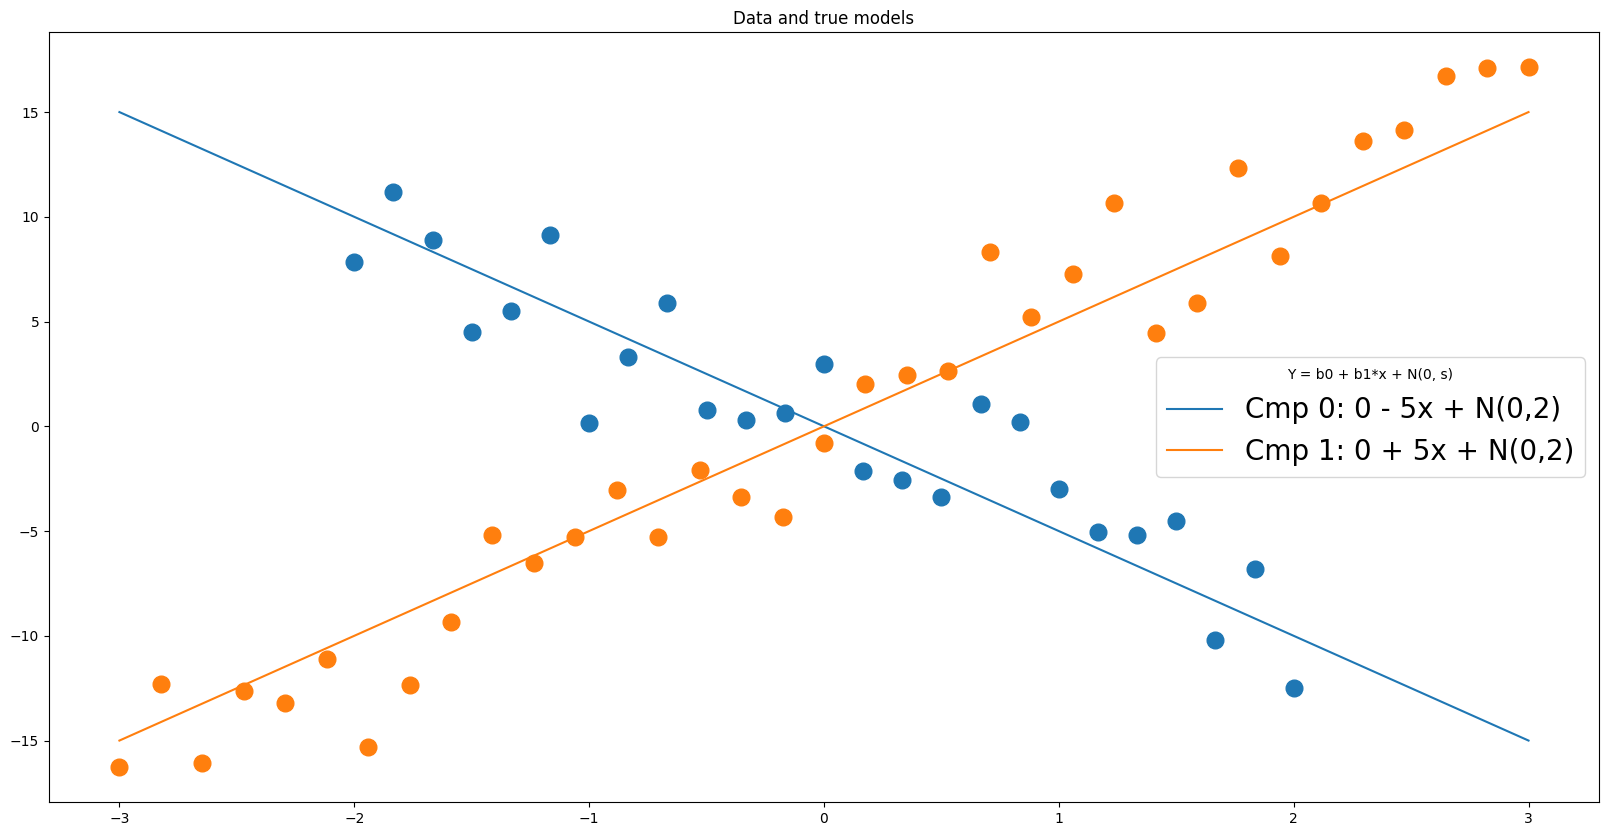

In [6]:
fig = plot_true_model((x1, x2), (y1, y2), b0, b1, sigma)

The function below shows all the data without distinguishing between data generated by component 1 and data generated by components 2.

In [7]:
def plot_data(xs, ys):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title("Data")
    for x, y in zip(xs, ys):
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color="gray",
        )
    return fig

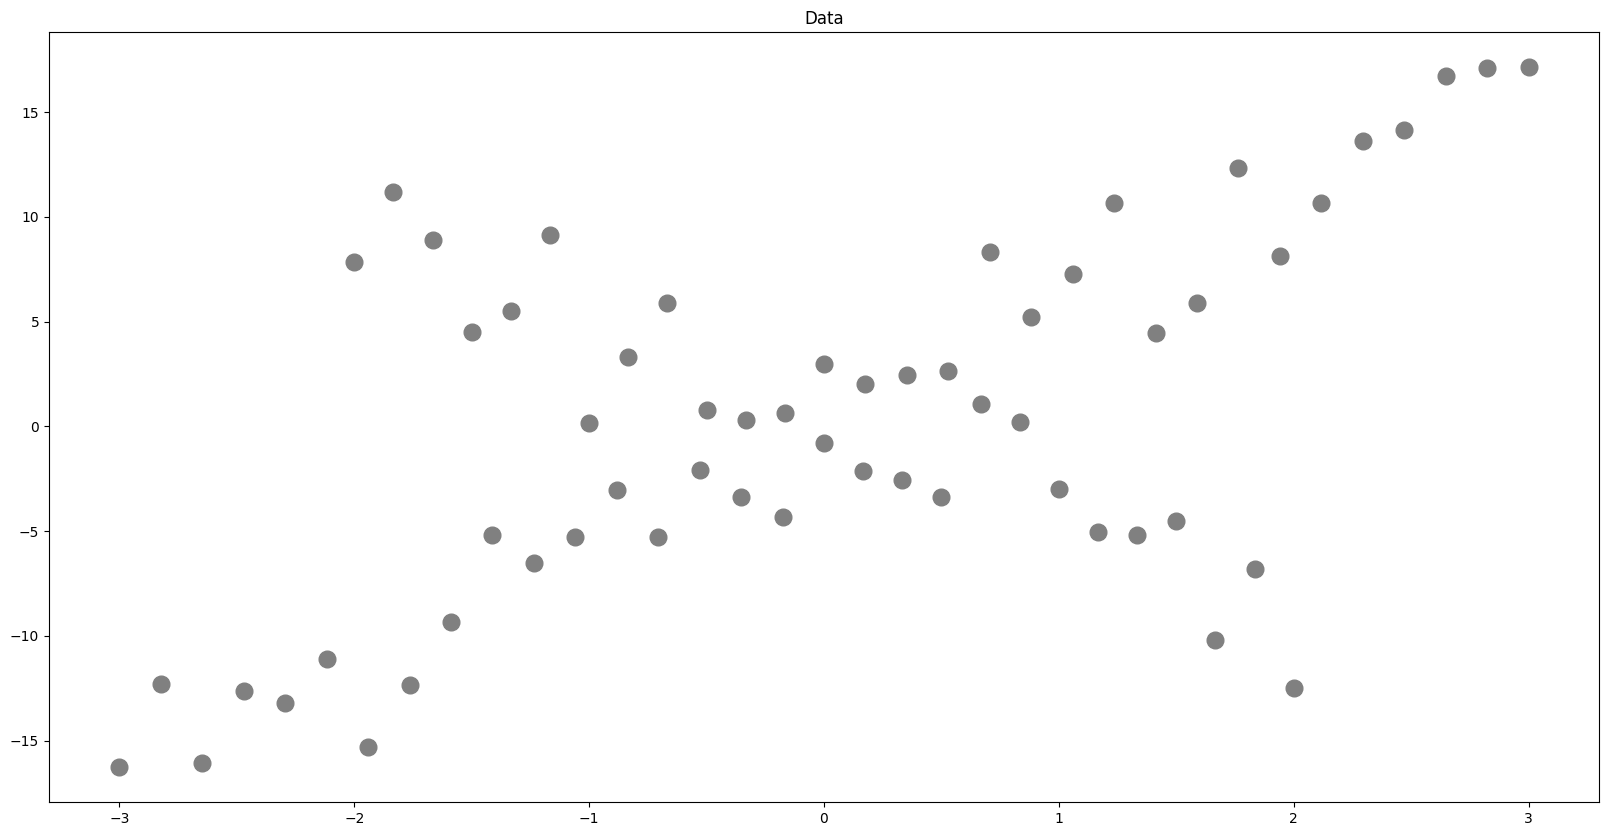

In [8]:
fig = plot_data((x1, x2), (y1, y2))

## Curve fit - known classes

Before we proceed let's analyze the two data set individually using a curve fit approach i.e minimize the square residuals to give the maximum likelihood estimate for the model parameters. We have also shown the confidence interval (uncertainty of the mean outcome), the estimate for σ and the parameter covariance matrix.

In [9]:
def plot_curve_fit(xs, ys):
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for i, (x, y) in enumerate(zip(xs, ys), 1):
        popt, pcov = curve_fit(model, x, y)

        # Standard errors
        perr = np.sqrt(np.diag(pcov))

        # sigma
        sigma = np.std(model(x, *popt) - y)

        # x_ = sm.add_constant(x)
        # lin_model = sm.OLS(y, x_)
        # results = lin_model.fit()
        # print(results.summary())
        # print("Statsmodels")
        # print("params", results.params)
        # print("std err", results.bse)
        # print("cov1", results.cov_params())

        print(f"CMP {i}")
        print("popt", popt)
        print("perr", perr)
        print("pcov", np.array2string(pcov, precision=2).replace("\n", ""))
        print("sigma", sigma)
        print()

        color = next(colors)

        sns.regplot(
            x=x,
            y=y,
            ci=95,
            order=1,
            line_kws={
                "label": f"CMP{i}. MLE={popt} (σ={sigma})",
                "color": color,
            },
            scatter_kws={
                "s": 144,
            },
            seed=1,
            label=f"CMP{i} data.",
            truncate=False,
            color=color,
            ax=axs[0],
        )

        plot_parameters(popt, pcov, axs[1], f"CMP{i}", nstds=[2], color=color)

    axs[0].set_xlabel("x", fontsize=NORMAL_FONTSIZE)
    axs[0].set_ylabel("y", fontsize=NORMAL_FONTSIZE)
    axs[0].legend(fontsize=20)

    axs[1].legend(fontsize=20)
    axs[1].set_xlabel("b0", fontsize=NORMAL_FONTSIZE)
    axs[1].set_ylabel("b1", fontsize=NORMAL_FONTSIZE)

    for ax in axs.flat:
        ax.tick_params(axis="both", which="major", labelsize=NORMAL_FONTSIZE)

    fig.suptitle("MLE parameters inferred from true classes")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

    return fig


CMP 1
popt [ 0.28020561 -4.49188226]
perr [0.48690263 0.40512748]
pcov [[2.37e-01 1.09e-10] [1.09e-10 1.64e-01]]
sigma 2.335102980159669

CMP 2
popt [0.1190518  5.64646829]
perr [0.35775744 0.20073186]
pcov [[ 1.28e-01 -3.79e-09] [-3.79e-09  4.03e-02]]
sigma 2.0551602386671677



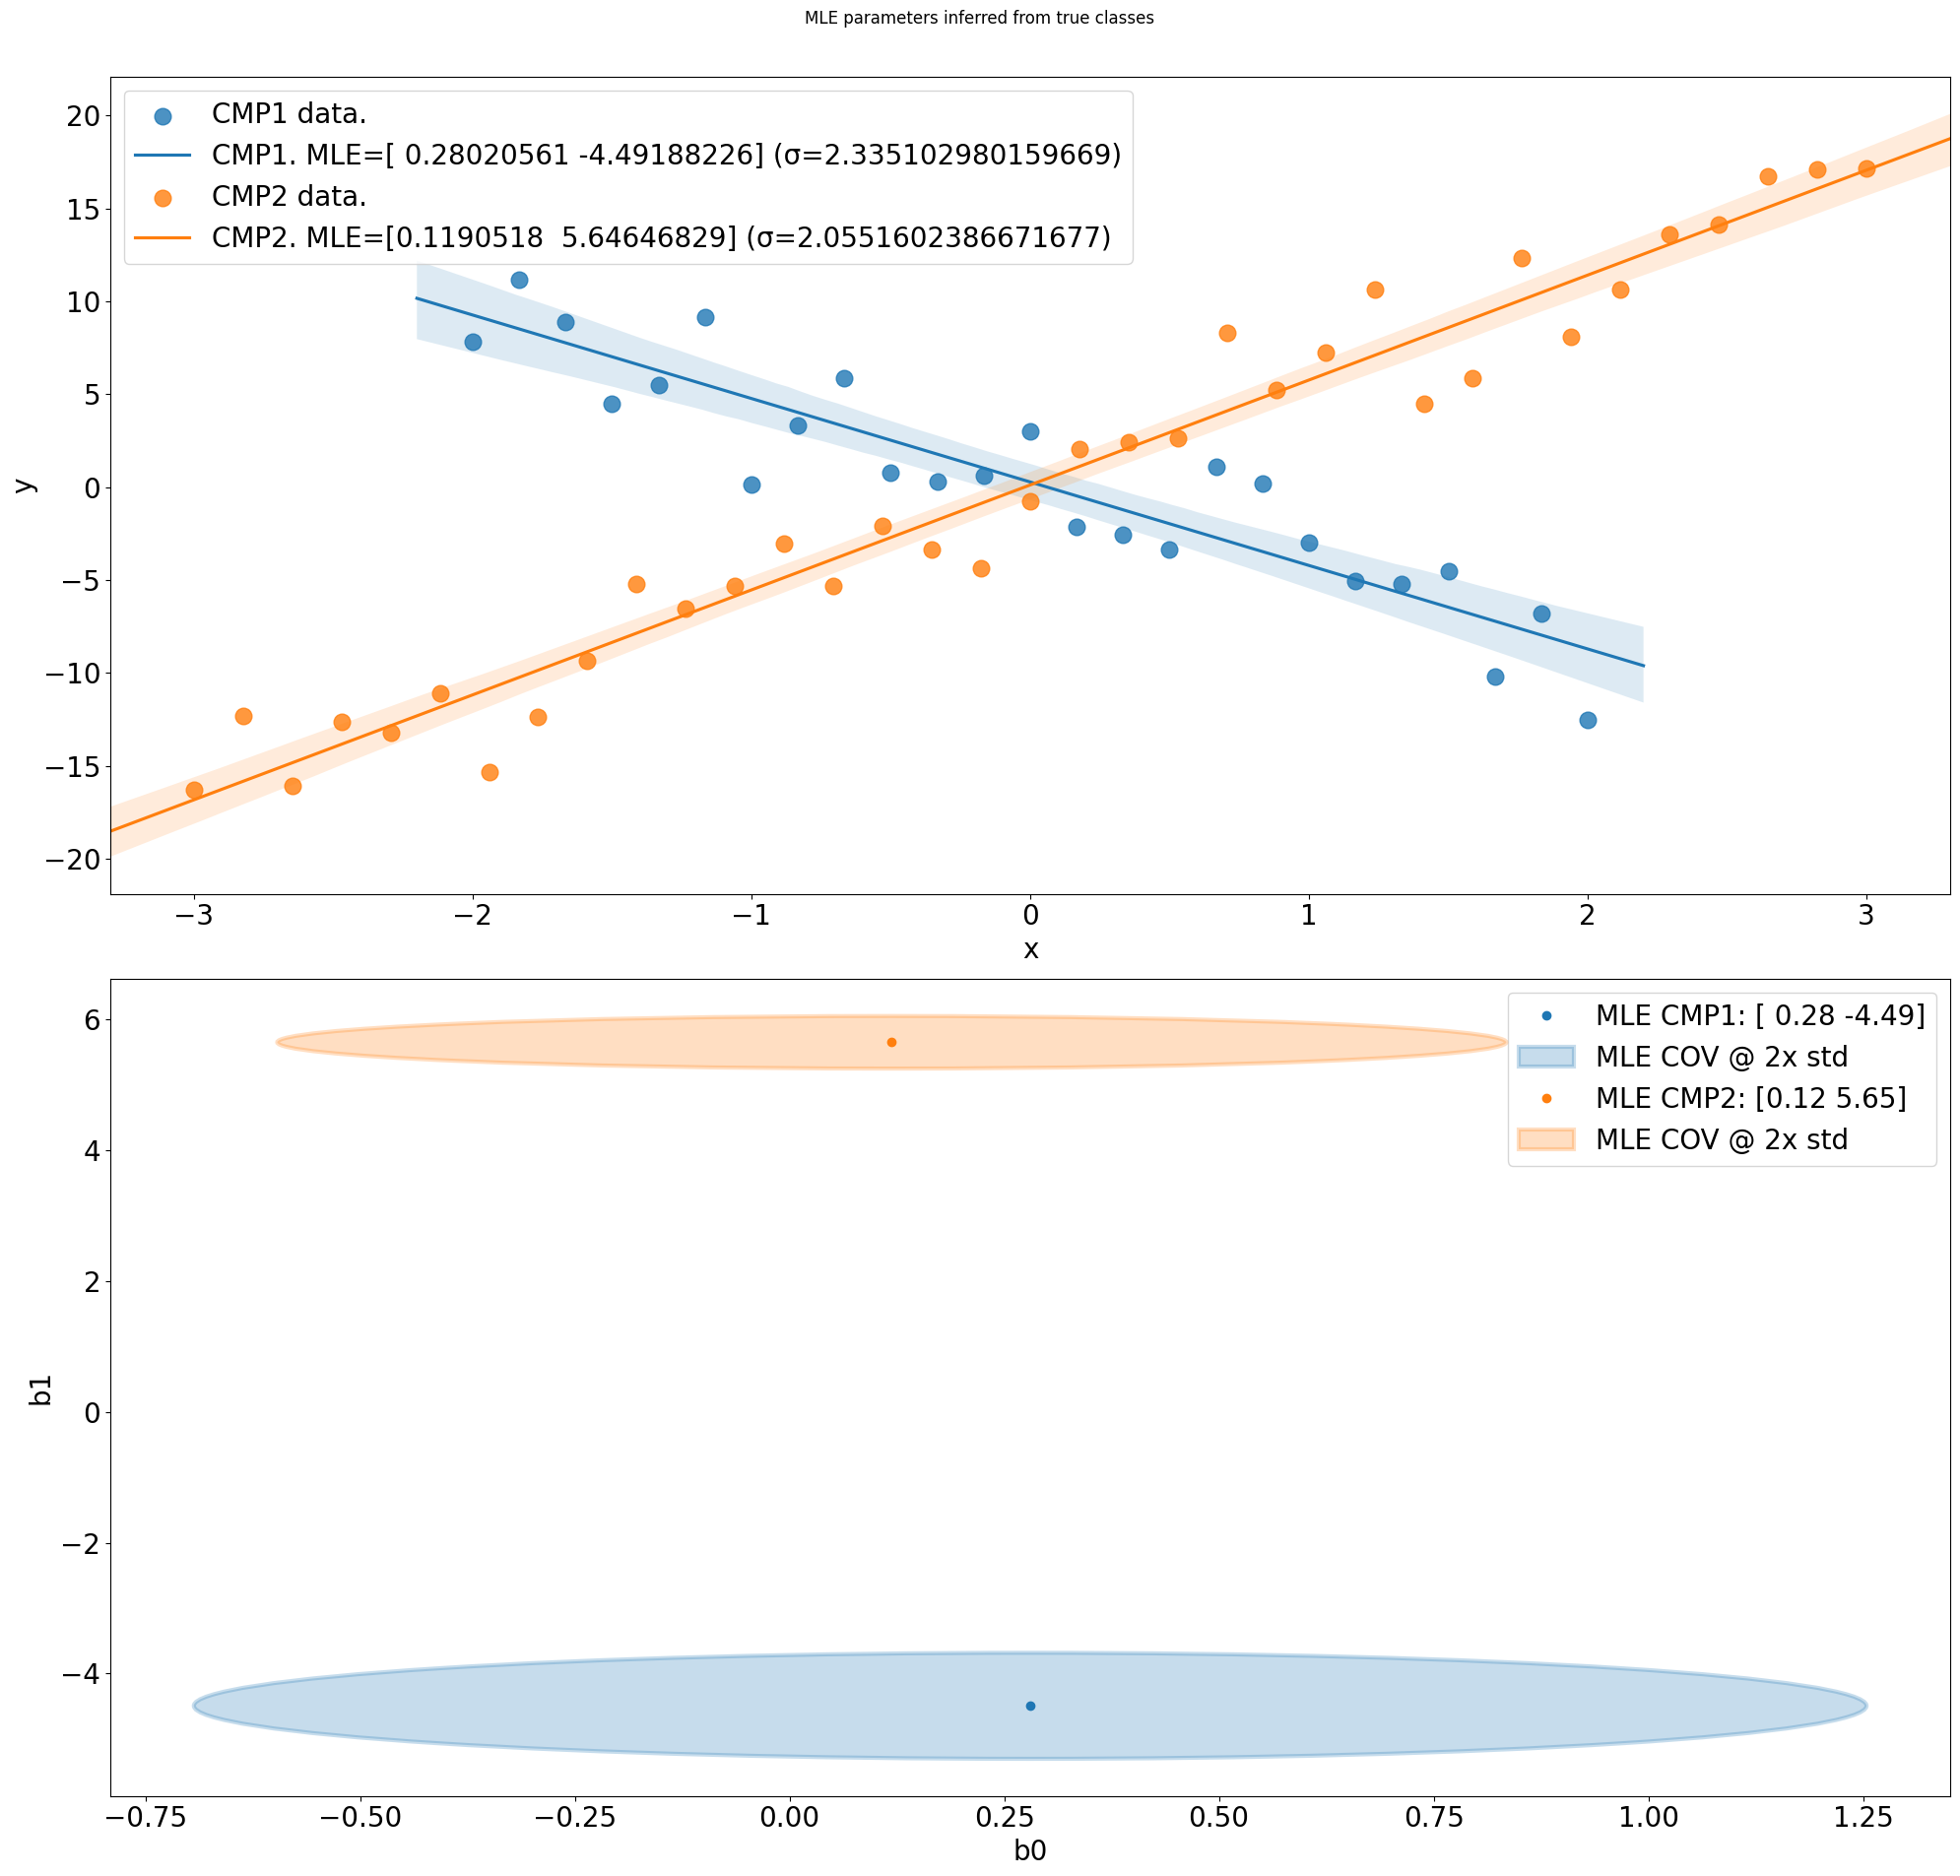

In [10]:
fig = plot_curve_fit((x1, x2), (y1, y2))

## Bayesian inference - known classes

First define a linear model. We do this explicitly showing how the model is composed. 

In [18]:
def fit_c1(X1, Y, return_inferencedata: bool = False, nsteps: int = 10000, nchains: int = 4):
    """One-component "mixture" """
    model = pm.Model()
    with model:
        b0 = pm.Normal("b0", 0, sigma=20)
        b1 = pm.Normal("b1", 0, sigma=20)
        y_est = b0 + b1 * X1
        sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        likelihood = pm.Normal("y", mu=y_est, sigma=sigma, observed=Y)

        trace = pm.sample(
            nsteps, return_inferencedata=return_inferencedata, chains=nchains
        )
        return trace, model


In [19]:
def plot_bayesian_fit(xs, ys, nsteps=25000, do_ppc: bool = True):
    # Bayesian inference for the true classes
    point_estimate = "mean"
    var_names = ["b0", "b1", "sigma"]
    var_names_pairs = ["b0", "b1"]

    fig_posterior, axs = plt.subplots(len(xs), len(var_names), figsize=(20, 20))
    fig_pair, axs_pair = plt.subplots(len(xs), 1, figsize=(20, 20))

    hdi_prob = az.rcParams["stats.hdi_prob"]

    if do_ppc is not None:
        fig_gppc, axs_gppc = plt.subplots(len(xs), 1, figsize=(20, 20))
        fig_mppc, axs_mppc = plt.subplots(len(xs), 1, figsize=(20, 20))
    else:
        fig_gppc = None
        fig_mppc = None

    for i, (x, y) in enumerate(zip(xs, ys)):

        trace, model = fit_c1(
            x,
            y,
            nsteps=nsteps,
            return_inferencedata=True,
        )

        az.plot_posterior(
            trace,
            var_names=var_names,
            point_estimate=point_estimate,
            ax=axs[i, :],
        )

        az.plot_pair(
            trace,
            var_names=var_names_pairs,
            kind="kde",
            point_estimate="mean",
            divergences=True,
            textsize=18,
            ax=axs_pair[i],
        )

        if do_ppc:
            with model:
                ppc = pm.sample_posterior_predictive(
                    trace, var_names=["b0", "b1", "y"], random_seed=RANDOM_SEED
                )

            az.plot_ppc(
                az.from_pymc3(posterior_predictive=ppc, model=model), ax=axs_gppc[i]
            )

            mu_pp = (ppc["b0"] + ppc["b1"] * x[:, None]).T
            axs_mppc[i].plot(x, y, "o", ms=4, alpha=0.4, label="Data")
            axs_mppc[i].plot(x, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
            az.plot_hdi(
                x,
                mu_pp,
                ax=axs_mppc[i],
                fill_kwargs={"alpha": 0.8, "label": f"Mean outcome {hdi_prob} % HPD"},
            )

            az.plot_hdi(
                x,
                ppc["y"],
                ax=axs_mppc[i],
                fill_kwargs={
                    "alpha": 0.8,
                    "color": "#a1dab4",
                    "label": f"Outcome {hdi_prob} % HPD",
                },
            )

            axs_mppc[i].set_xlabel("Predictor")
            axs_mppc[i].set_ylabel("Outcome")
            axs_mppc[i].set_title("Posterior predictive checks")
            axs_mppc[i].legend(ncol=2, fontsize=12)

    return fig_posterior, fig_pair, fig_gppc, fig_mppc


In [20]:
do_ppc = True
fig, fig_pair, fig_gppc, fig_mppc = plot_bayesian_fit(
    (x1, x2),
    (y1, y2),
    nsteps=10000,
    do_ppc=do_ppc,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


In [15]:
%watermark

UsageError: Line magic function `%watermark` not found.
